In [1]:
!pip install editdistance -q
!pip install sacrebleu -q

     |████████████████████████████████| 90 kB 4.0 MB/s 


In [2]:
# Mount Google drive to upload datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# The path to the data on my drive
D = '/content/drive/My Drive/W266_Project_Data/pmi_data'

In [4]:
import pandas as pd
import numpy as np
import editdistance
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Load the eval files for each model's translations
final = pd.read_csv(D+"/predicted_text/siamese_evaluations_of_translations/record_comparison_layernorm.csv")
final.drop(columns={'Unnamed: 0'}, inplace=True)

In [6]:
# View the first few records in each file
final.head()

,language_task,target_sentence,bart_translation,bart_paraphrase_score,bart_cosine_score,indictrans_translation,indictrans_paraphrase_score,indictrans_cosine_score,best_trans
0,translate English to Hindi,प्रधानमंत्री ने कहा कि बाबा साहेब अम्बेडकर की ...,Prime Minister said Babasaheb Ambedkar has a k...,0.296427,0.770237,प्रधानमंत्री ने कहा कि करोड़ों लोगों के दिलों ...,0.964050,0.948379,प्रधानमंत्री ने कहा कि करोड़ों लोगों के दिलों ...
1,translate English to Hindi,इस समारोह को आज बीजापुर में आयोजित करने के महत...,आज बीजापुर में इस समारोह को आयोजित करने के महत...,0.961452,0.946777,आज बीजापुर में इस कार्यक्रम के आयोजन के महत्व ...,0.975653,0.973164,आज बीजापुर में इस कार्यक्रम के आयोजन के महत्व ...
2,translate English to Hindi,उन्होंने कहा कि इस कार्य को 2022 तक पूरा कर ले...,उन्होंने कहा कि लक्ष्य 2022 तक इस कार्य को पूर...,0.984172,0.956433,उन्होंने कहा कि इस कार्य को 2022 तक पूरा करने ...,0.987264,0.985965,उन्होंने कहा कि इस कार्य को 2022 तक पूरा करने ...
3,translate English to Hindi,प्रधानमंत्री ने कहा कि सरकार स्पष्ट लक्ष्यों औ...,प्रधानमंत्री ने कहा कि सरकार स्पष्ट लक्ष्यों औ...,0.987658,0.965325,प्रधानमंत्री ने कहा कि सरकार स्पष्ट लक्ष्यों औ...,0.989116,0.986373,प्रधानमंत्री ने कहा कि सरकार स्पष्ट लक्ष्यों औ...
4,translate English to Hindi,"उन्होंने इस संदर्भ में जन धन खाता खोलने, गरीबो...","इस संदर्भ में उन्होंने जनधन खाते खोलने, गरीबों...",0.979594,0.979276,"इस संदर्भ में उन्होंने जन धन खाते खोलने, गरीबो...",0.986208,0.992806,"इस संदर्भ में उन्होंने जन धन खाते खोलने, गरीबो..."


In [7]:
# Add a new column for the source of the best translation
final['best_trans_source'] = np.where(final.best_trans == final.indictrans_translation, "indictrans", "mbart")

In [8]:
# Add a new column based upon whether or not cosine similarity score went up or down
conditions = [
    (final['best_trans_source'] == 'indictrans') & (final['indictrans_cosine_score'] > final['bart_cosine_score']),
    (final['best_trans_source'] == 'indictrans') & (final['indictrans_cosine_score'] < final['bart_cosine_score']),
    (final['best_trans_source'] == 'indictrans') & (final['indictrans_cosine_score'] == final['bart_cosine_score']),
    (final['best_trans_source'] == 'mbart') & (final['bart_cosine_score'] > final['indictrans_cosine_score']),
    (final['best_trans_source'] == 'mbart') & (final['bart_cosine_score'] < final['indictrans_cosine_score']),
    (final['best_trans_source'] == 'mbart') & (final['bart_cosine_score'] == final['bart_cosine_score'])
    ]
values = ['score increased', 'score decreased', 'no change', 'score increased', 'score decreased', 'no change']

final['cos_change'] = np.select(conditions, values)

In [9]:
# Create a scatterplot of cosine similarity scores and paraphrase probability scores
# Add a column for the best translation cosine similarity score and another for best translation paraphrase score
final['best_paraphrase_cos'] = np.where(final.best_trans_source == 'mbart', final.bart_cosine_score, final.indictrans_cosine_score)
final['best_paraphrase_para'] = np.where(final.best_trans_source == 'mbart', final.bart_paraphrase_score, final.indictrans_paraphrase_score)

In [10]:
final.language_task = final['language_task'].str.replace('translate English to Hindi', 'Hindi').str.replace('translate English to Tamil', 'Tamil').str.replace('translate English to Malayalam', 'Malayalam')

In [11]:
# The cosine similarity score of the sentence chosen by the paraphrase evaluator was higher than that of the non-chosen sentence 74% of the time
# 2,195 of 2,967 times
# in 772 cases, the cosine similarity score of the chosen sentence was lower than that of the non-chosen sentence
final.cos_change.value_counts()

score increased    2195
score decreased     772
no change            33
Name: cos_change, dtype: int64

In [12]:
# Add 2 new columns to calculate the character edit distance
# 1 between IndicTrans translation and target
# 1 for MBart translation and target
final['indictrans_edit'] = final.apply(lambda x: editdistance.eval(x['target_sentence'], x['indictrans_translation']), axis=1)
final['bart_edit'] = final.apply(lambda x: editdistance.eval(x['target_sentence'], x['bart_translation']), axis=1)

In [13]:
# Create a new column for the difference in edit distances between the translation chosen vs not chosen
final["editd_chosen"] = np.where(final.best_trans_source == 'mbart', final.bart_edit - final.indictrans_edit, 
                              final.indictrans_edit - final.bart_edit)

In [16]:
# Set a column for the edit distance of the translation labeled as best by our classifier
final['best_paraphrase_edit'] = np.where(final.best_trans_source == 'mbart', final.bart_edit, final.indictrans_edit)

In [17]:
# Create sub dataframes for each translator when it was chosen as the best translation
indic_chosen = final[final.best_trans_source == 'indictrans']
mbart_chosen = final[final.best_trans_source == 'mbart']

In [18]:
# When Indictrans was chosen as the translation, the cosine similarity was higher than that the Bart translation 1,485 times out of 1,928
# 77% of the time
# The 33 times that there was no change was when the translators produced the same translation, so we'll exclude these from the percentage
indic_chosen.cos_change.value_counts()

score increased    1485
score decreased     443
no change            33
Name: cos_change, dtype: int64

In [19]:
# Mbart's translation was chosen as the better translation 710 of 1039 times
# 68% of the time, this replacement resulted in an increase in sentence similarity as measured by cosine similarity score
mbart_chosen.cos_change.value_counts()

score increased    710
score decreased    329
Name: cos_change, dtype: int64

In [20]:
final.columns

Index(['language_task', 'target_sentence', 'bart_translation',
       'bart_paraphrase_score', 'bart_cosine_score', 'indictrans_translation',
       'indictrans_paraphrase_score', 'indictrans_cosine_score', 'best_trans',
       'best_trans_source', 'cos_change', 'best_paraphrase_cos',
       'best_paraphrase_para', 'indictrans_edit', 'bart_edit', 'editd_chosen',
       'best_paraphrase_edit'],
      dtype='object')

In [21]:
# Look at langage specific changes in cosine sentence similarity, then by language + translator used
# Initial Sacre Bleu scores were highest for Hindi from IndicTrans, MBart for Tamil, and IndicTrans for Malayalam
hi_cos_change = final[final.language_task == 'Hindi']
ta_cos_change = final[final.language_task == 'Tamil']
ml_cos_change = final[final.language_task == 'Malayalam']

In [22]:
# 786 of 976 times, the cosine similarity score for Hindi increased
# an additional 24 times there was no change
hi_cos_change.cos_change.value_counts()

score increased    786
score decreased    190
no change           24
Name: cos_change, dtype: int64

In [23]:
print(hi_cos_change[hi_cos_change.best_trans_source == 'indictrans'].cos_change.value_counts(), "\n")
print(hi_cos_change[hi_cos_change.best_trans_source == 'mbart'].cos_change.value_counts())

score increased    569
score decreased    102
no change           24
Name: cos_change, dtype: int64 

score increased    217
score decreased     88
Name: cos_change, dtype: int64


In [24]:
print(ta_cos_change.cos_change.value_counts(), "\n")
print(ta_cos_change[ta_cos_change.best_trans_source == 'indictrans'].cos_change.value_counts(), "\n")
print(ta_cos_change[ta_cos_change.best_trans_source == 'mbart'].cos_change.value_counts())

score increased    703
score decreased    288
no change            9
Name: cos_change, dtype: int64 

score increased    396
score decreased    132
no change            9
Name: cos_change, dtype: int64 

score increased    307
score decreased    156
Name: cos_change, dtype: int64


In [25]:
print(ml_cos_change.cos_change.value_counts(), "\n")
print(ml_cos_change[ml_cos_change.best_trans_source == 'indictrans'].cos_change.value_counts(), "\n")
print(ml_cos_change[ml_cos_change.best_trans_source == 'mbart'].cos_change.value_counts())

score increased    706
score decreased    294
Name: cos_change, dtype: int64 

score increased    520
score decreased    209
Name: cos_change, dtype: int64 

score increased    186
score decreased     85
Name: cos_change, dtype: int64


In [26]:
# See if the chosen translation has a higher/lower/the same character edit distance as the translation not chosen
print(len(indic_chosen[indic_chosen.indictrans_edit < indic_chosen.bart_edit]))
print(len(indic_chosen[indic_chosen.indictrans_edit == indic_chosen.bart_edit]))
print(len(indic_chosen[indic_chosen.indictrans_edit > indic_chosen.bart_edit]))

1509
84
368


In [27]:
print(len(mbart_chosen[mbart_chosen.bart_edit < mbart_chosen.indictrans_edit]))
print(len(mbart_chosen[mbart_chosen.bart_edit == mbart_chosen.indictrans_edit]))
print(len(mbart_chosen[mbart_chosen.bart_edit > mbart_chosen.indictrans_edit]))

416
47
576


In [28]:
hi_cos_change.columns

Index(['language_task', 'target_sentence', 'bart_translation',
       'bart_paraphrase_score', 'bart_cosine_score', 'indictrans_translation',
       'indictrans_paraphrase_score', 'indictrans_cosine_score', 'best_trans',
       'best_trans_source', 'cos_change', 'best_paraphrase_cos',
       'best_paraphrase_para', 'indictrans_edit', 'bart_edit', 'editd_chosen',
       'best_paraphrase_edit'],
      dtype='object')

In [29]:
hi_cos_change.head()

,language_task,target_sentence,bart_translation,bart_paraphrase_score,bart_cosine_score,indictrans_translation,indictrans_paraphrase_score,indictrans_cosine_score,best_trans,best_trans_source,cos_change,best_paraphrase_cos,best_paraphrase_para,indictrans_edit,bart_edit,editd_chosen,best_paraphrase_edit
0,Hindi,प्रधानमंत्री ने कहा कि बाबा साहेब अम्बेडकर की ...,Prime Minister said Babasaheb Ambedkar has a k...,0.296427,0.770237,प्रधानमंत्री ने कहा कि करोड़ों लोगों के दिलों ...,0.964050,0.948379,प्रधानमंत्री ने कहा कि करोड़ों लोगों के दिलों ...,indictrans,score increased,0.948379,0.964050,67,126,-59,67
1,Hindi,इस समारोह को आज बीजापुर में आयोजित करने के महत...,आज बीजापुर में इस समारोह को आयोजित करने के महत...,0.961452,0.946777,आज बीजापुर में इस कार्यक्रम के आयोजन के महत्व ...,0.975653,0.973164,आज बीजापुर में इस कार्यक्रम के आयोजन के महत्व ...,indictrans,score increased,0.973164,0.975653,56,43,13,56
2,Hindi,उन्होंने कहा कि इस कार्य को 2022 तक पूरा कर ले...,उन्होंने कहा कि लक्ष्य 2022 तक इस कार्य को पूर...,0.984172,0.956433,उन्होंने कहा कि इस कार्य को 2022 तक पूरा करने ...,0.987264,0.985965,उन्होंने कहा कि इस कार्य को 2022 तक पूरा करने ...,indictrans,score increased,0.985965,0.987264,3,26,-23,3
3,Hindi,प्रधानमंत्री ने कहा कि सरकार स्पष्ट लक्ष्यों औ...,प्रधानमंत्री ने कहा कि सरकार स्पष्ट लक्ष्यों औ...,0.987658,0.965325,प्रधानमंत्री ने कहा कि सरकार स्पष्ट लक्ष्यों औ...,0.989116,0.986373,प्रधानमंत्री ने कहा कि सरकार स्पष्ट लक्ष्यों औ...,indictrans,score increased,0.986373,0.989116,3,3,0,3
4,Hindi,"उन्होंने इस संदर्भ में जन धन खाता खोलने, गरीबो...","इस संदर्भ में उन्होंने जनधन खाते खोलने, गरीबों...",0.979594,0.979276,"इस संदर्भ में उन्होंने जन धन खाते खोलने, गरीबो...",0.986208,0.992806,"इस संदर्भ में उन्होंने जन धन खाते खोलने, गरीबो...",indictrans,score increased,0.992806,0.986208,38,58,-20,38


In [30]:
# Print the edit distance for Hindi by translator chosen
# For Hindi, when IndicTrans was chosen as the best translator, it usually had a shorter edit distance
print(len(hi_cos_change[(hi_cos_change.best_trans_source == 'indictrans') & (hi_cos_change.indictrans_edit < hi_cos_change.bart_edit)]))
print(len(hi_cos_change[(hi_cos_change.best_trans_source == 'indictrans') & (hi_cos_change.indictrans_edit == hi_cos_change.bart_edit)]))
print(len(hi_cos_change[(hi_cos_change.best_trans_source == 'indictrans') & (hi_cos_change.indictrans_edit > hi_cos_change.bart_edit)]), "\n")

# For Hindi, when Bart was chosen as the best translator, 49% of the time, the IndicTrans translation had a smaller edit distance
print(len(hi_cos_change[(hi_cos_change.best_trans_source == 'mbart') & (hi_cos_change.bart_edit < hi_cos_change.indictrans_edit)]))
print(len(hi_cos_change[(hi_cos_change.best_trans_source == 'mbart') & (hi_cos_change.bart_edit == hi_cos_change.indictrans_edit)]))
print(len(hi_cos_change[(hi_cos_change.best_trans_source == 'mbart') & (hi_cos_change.bart_edit > hi_cos_change.indictrans_edit)]))

535
47
113 

145
11
149


In [31]:
# Print the edit distance for Tamil by translator chosen
# For Tamil, when IndicTrans was chosen as the best translator, it usually had a shorter edit distance
print(len(ta_cos_change[(ta_cos_change.best_trans_source == 'indictrans') & (ta_cos_change.indictrans_edit < ta_cos_change.bart_edit)]))
print(len(ta_cos_change[(ta_cos_change.best_trans_source == 'indictrans') & (ta_cos_change.indictrans_edit == ta_cos_change.bart_edit)]))
print(len(ta_cos_change[(ta_cos_change.best_trans_source == 'indictrans') & (ta_cos_change.indictrans_edit > ta_cos_change.bart_edit)]), "\n")

# For Tamil, when Bart was chosen as the best translator, 49% of the time, the IndicTrans translation had a smaller edit distance
print(len(ta_cos_change[(ta_cos_change.best_trans_source == 'mbart') & (ta_cos_change.bart_edit < ta_cos_change.indictrans_edit)]))
print(len(ta_cos_change[(ta_cos_change.best_trans_source == 'mbart') & (ta_cos_change.bart_edit == ta_cos_change.indictrans_edit)]))
print(len(ta_cos_change[(ta_cos_change.best_trans_source == 'mbart') & (ta_cos_change.bart_edit > ta_cos_change.indictrans_edit)]))

339
24
174 

209
25
229


In [32]:
# For Malayalam, when IndicTrans was chosen as the best translator, it usually had a shorter edit distance
print(len(ml_cos_change[(ml_cos_change.best_trans_source == 'indictrans') & (ml_cos_change.indictrans_edit < ml_cos_change.bart_edit)]))
print(len(ml_cos_change[(ml_cos_change.best_trans_source == 'indictrans') & (ml_cos_change.indictrans_edit == ml_cos_change.bart_edit)]))
print(len(ml_cos_change[(ml_cos_change.best_trans_source == 'indictrans') & (ml_cos_change.indictrans_edit > ml_cos_change.bart_edit)]), "\n")

# For Malayalam, when Bart was chosen as the best translator, the edit distance from the translated sentence to the target
# tends to be greater than the edit distances of the translated sentences from IndicTrans
print(len(ml_cos_change[(ml_cos_change.best_trans_source == 'mbart') & (ml_cos_change.bart_edit < ml_cos_change.indictrans_edit)]))
print(len(ml_cos_change[(ml_cos_change.best_trans_source == 'mbart') & (ml_cos_change.bart_edit == ml_cos_change.indictrans_edit)]))
print(len(ml_cos_change[(ml_cos_change.best_trans_source == 'mbart') & (ml_cos_change.bart_edit > ml_cos_change.indictrans_edit)]))

635
13
81 

62
11
198


In [33]:
# We'll now create corpuses for each language - for IndicTrans translations when chosen and their target texts
hi_indict = indic_chosen[indic_chosen.language_task == 'Hindi']
ta_indict = indic_chosen[indic_chosen.language_task == 'Tamil']
ml_indict = indic_chosen[indic_chosen.language_task == 'Malayalam']

# And again for the MBart translations when chosen and their target texts
hi_mbart = mbart_chosen[mbart_chosen.language_task == 'Hindi']
ta_mbart = mbart_chosen[mbart_chosen.language_task == 'Tamil']
ml_mbart = mbart_chosen[mbart_chosen.language_task == 'Malayalam']

# Save the target translations and the best translations for each language to a separate txt file
np.savetxt(D+"/predicted_text/siamese_evaluations_of_translations/indict_hi_target_layernorm.txt", hi_indict.target_sentence.values, fmt='%s', newline='\n')
np.savetxt(D+"/predicted_text/siamese_evaluations_of_translations/indict_hi_trans_layernorm.txt", hi_indict.best_trans.values, fmt='%s', newline='\n')
np.savetxt(D+"/predicted_text/siamese_evaluations_of_translations/indict_ta_target_layernorm.txt", ta_indict.target_sentence.values, fmt='%s', newline='\n')
np.savetxt(D+"/predicted_text/siamese_evaluations_of_translations/indict_ta_trans_layernorm.txt", ta_indict.best_trans.values, fmt='%s', newline='\n')
np.savetxt(D+"/predicted_text/siamese_evaluations_of_translations/indict_ml_target_layernorm.txt", ml_indict.target_sentence.values, fmt='%s', newline='\n')
np.savetxt(D+"/predicted_text/siamese_evaluations_of_translations/indict_ml_trans_layernorm.txt", ml_indict.best_trans.values, fmt='%s', newline='\n')

np.savetxt(D+"/predicted_text/siamese_evaluations_of_translations/mbart_hi_target_layernorm.txt", hi_mbart.target_sentence.values, fmt='%s', newline='\n')
np.savetxt(D+"/predicted_text/siamese_evaluations_of_translations/mbart_hi_trans_layernorm.txt", hi_mbart.best_trans.values, fmt='%s', newline='\n')
np.savetxt(D+"/predicted_text/siamese_evaluations_of_translations/mbart_ta_target_layernorm.txt", ta_mbart.target_sentence.values, fmt='%s', newline='\n')
np.savetxt(D+"/predicted_text/siamese_evaluations_of_translations/mbart_ta_trans_layernorm.txt", ta_mbart.best_trans.values, fmt='%s', newline='\n')
np.savetxt(D+"/predicted_text/siamese_evaluations_of_translations/mbart_ml_target_layernorm.txt", ml_mbart.target_sentence.values, fmt='%s', newline='\n')
np.savetxt(D+"/predicted_text/siamese_evaluations_of_translations/mbart_ml_trans_layernorm.txt", ml_mbart.best_trans.values, fmt='%s', newline='\n')

In [34]:
# cd into the directory where the files are saved then compute Sacre Bleu scores
%cd /content/drive/MyDrive/W266_Project_Data/pmi_data/predicted_text/siamese_evaluations_of_translations/

/content/drive/MyDrive/W266_Project_Data/pmi_data/predicted_text/siamese_evaluations_of_translations


In [35]:
# Get the Hindi Sacre Bleu scores when IndicTrans is chosen as the "better translation"
!sacrebleu indict_hi_trans_layernorm.txt -i indict_hi_target_layernorm.txt --tokenize intl

# Get the Hindi Sacre Bleu scores when MBart is chosen as the "better translation"
!sacrebleu mbart_hi_trans_layernorm.txt -i mbart_hi_target_layernorm.txt --tokenize intl

{
 "name": "BLEU",
 "score": 42.7,
 "signature": "nrefs:1|case:mixed|eff:no|tok:intl|smooth:exp|version:2.0.0",
 "verbose_score": "70.6/49.5/35.7/26.5 (BP = 1.000 ratio = 1.027 hyp_len = 13765 ref_len = 13402)",
 "nrefs": "1",
 "case": "mixed",
 "eff": "no",
 "tok": "intl",
 "smooth": "exp",
 "version": "2.0.0"
}
{
 "name": "BLEU",
 "score": 28.8,
 "signature": "nrefs:1|case:mixed|eff:no|tok:intl|smooth:exp|version:2.0.0",
 "verbose_score": "61.2/36.0/22.3/13.9 (BP = 1.000 ratio = 1.008 hyp_len = 5792 ref_len = 5745)",
 "nrefs": "1",
 "case": "mixed",
 "eff": "no",
 "tok": "intl",
 "smooth": "exp",
 "version": "2.0.0"
}


In [36]:
# Repeat for Malayalam
!sacrebleu indict_ml_trans_layernorm.txt -i indict_ml_target_layernorm.txt --tokenize intl
!sacrebleu mbart_ml_trans_layernorm.txt -i mbart_ml_target_layernorm.txt --tokenize intl

{
 "name": "BLEU",
 "score": 9.2,
 "signature": "nrefs:1|case:mixed|eff:no|tok:intl|smooth:exp|version:2.0.0",
 "verbose_score": "38.5/13.2/5.7/2.4 (BP = 1.000 ratio = 1.007 hyp_len = 8762 ref_len = 8705)",
 "nrefs": "1",
 "case": "mixed",
 "eff": "no",
 "tok": "intl",
 "smooth": "exp",
 "version": "2.0.0"
}
{
 "name": "BLEU",
 "score": 1.7,
 "signature": "nrefs:1|case:mixed|eff:no|tok:intl|smooth:exp|version:2.0.0",
 "verbose_score": "25.2/3.4/0.7/0.3 (BP = 0.852 ratio = 0.862 hyp_len = 3167 ref_len = 3676)",
 "nrefs": "1",
 "case": "mixed",
 "eff": "no",
 "tok": "intl",
 "smooth": "exp",
 "version": "2.0.0"
}


In [37]:
# Repeat for Tamil
!sacrebleu indict_ta_trans_layernorm.txt -i indict_ta_target_layernorm.txt --tokenize intl
!sacrebleu mbart_ta_trans_layernorm.txt -i mbart_ta_target_layernorm.txt --tokenize intl

{
 "name": "BLEU",
 "score": 17.1,
 "signature": "nrefs:1|case:mixed|eff:no|tok:intl|smooth:exp|version:2.0.0",
 "verbose_score": "47.5/22.5/12.1/6.7 (BP = 1.000 ratio = 1.049 hyp_len = 7755 ref_len = 7391)",
 "nrefs": "1",
 "case": "mixed",
 "eff": "no",
 "tok": "intl",
 "smooth": "exp",
 "version": "2.0.0"
}
{
 "name": "BLEU",
 "score": 13.5,
 "signature": "nrefs:1|case:mixed|eff:no|tok:intl|smooth:exp|version:2.0.0",
 "verbose_score": "43.4/18.5/9.0/4.6 (BP = 1.000 ratio = 1.042 hyp_len = 6670 ref_len = 6400)",
 "nrefs": "1",
 "case": "mixed",
 "eff": "no",
 "tok": "intl",
 "smooth": "exp",
 "version": "2.0.0"
}


So when Bart is considered to have produced the better translation, its sentences have less overlap with the target than do the translated sentences from IndicTrans when it is considered the better translator.
Let's look at scores for the same sentences.

In [38]:
# Save the Bart translations when IndicTrans is considered the better translator
np.savetxt(D+"/predicted_text/siamese_evaluations_of_translations/hi_bart_bestindic_layernorm.txt", 
           hi_indict.bart_translation.values, fmt='%s', newline='\n')
np.savetxt(D+"/predicted_text/siamese_evaluations_of_translations/ml_bart_bestindic_layernorm.txt", 
           ml_indict.bart_translation.values, fmt='%s', newline='\n')
np.savetxt(D+"/predicted_text/siamese_evaluations_of_translations/ta_bart_bestindic_layernorm.txt", 
           ta_indict.bart_translation.values, fmt='%s', newline='\n')

When IndicTrans translations are chosen as the "better" translation, their Sacre Bleu scores are higher than the MBart sentences that were not chosen (as seen below). However (as seen below), MBart chosen sentences have lower Sacre Bleu scores for Hindi than their IndicTrans counterparts that were not chosen. The SacreBleu scores of MBart chosen and IndicTrans not chosen sentences are equivalent for Tamil.

In [39]:
# Get the Sacre Bleu scores for the MBart translations for Hindi, Tamil, and Malayam, when IndicTrans is considered better
# The Hindi score is 27.8 vs 42.7 from IndicTrans
!sacrebleu hi_bart_bestindic_layernorm.txt -i indict_hi_target_layernorm.txt --tokenize intl
# The Malayalam score is 1.1 vs 9.2 from IndicTrans
!sacrebleu ml_bart_bestindic_layernorm.txt -i indict_ml_target_layernorm.txt --tokenize intl
# The Tamil score is 12.5 vs 17.1 from IndicTrans
!sacrebleu ta_bart_bestindic_layernorm.txt -i indict_ta_target_layernorm.txt --tokenize intl

{
 "name": "BLEU",
 "score": 27.8,
 "signature": "nrefs:1|case:mixed|eff:no|tok:intl|smooth:exp|version:2.0.0",
 "verbose_score": "58.7/34.6/21.4/13.6 (BP = 1.000 ratio = 1.029 hyp_len = 13765 ref_len = 13372)",
 "nrefs": "1",
 "case": "mixed",
 "eff": "no",
 "tok": "intl",
 "smooth": "exp",
 "version": "2.0.0"
}
{
 "name": "BLEU",
 "score": 1.1,
 "signature": "nrefs:1|case:mixed|eff:no|tok:intl|smooth:exp|version:2.0.0",
 "verbose_score": "22.8/2.9/0.5/0.1 (BP = 0.797 ratio = 0.815 hyp_len = 8762 ref_len = 10753)",
 "nrefs": "1",
 "case": "mixed",
 "eff": "no",
 "tok": "intl",
 "smooth": "exp",
 "version": "2.0.0"
}
{
 "name": "BLEU",
 "score": 12.5,
 "signature": "nrefs:1|case:mixed|eff:no|tok:intl|smooth:exp|version:2.0.0",
 "verbose_score": "41.3/16.8/8.3/4.2 (BP = 1.000 ratio = 1.062 hyp_len = 7755 ref_len = 7305)",
 "nrefs": "1",
 "case": "mixed",
 "eff": "no",
 "tok": "intl",
 "smooth": "exp",
 "version": "2.0.0"
}


In [40]:
# Save the IndicTrans translations when MBart is considered the better translator
np.savetxt(D+"/predicted_text/siamese_evaluations_of_translations/hi_indict_bestbart_layernorm.txt", 
           hi_mbart.indictrans_translation.values, fmt='%s', newline='\n')
np.savetxt(D+"/predicted_text/siamese_evaluations_of_translations/ml_indict_bestbart_layernorm.txt", 
           ml_mbart.bart_translation.values, fmt='%s', newline='\n')
np.savetxt(D+"/predicted_text/siamese_evaluations_of_translations/ta_indict_bestbart_layernorm.txt", 
           ta_mbart.bart_translation.values, fmt='%s', newline='\n')

In [41]:
# When MBart is considered to have produced the better translation
# The Hindi IndicTrans scores are 30.2 vs 28.8 from MBart
!sacrebleu hi_indict_bestbart_layernorm.txt -i mbart_hi_target_layernorm.txt --tokenize intl
# The Malayalam IndicTrans scores are 1.7 vs 1.7 from MBart
!sacrebleu ml_indict_bestbart_layernorm.txt -i mbart_ml_target_layernorm.txt --tokenize intl
# The Tamil IndicTrans scores are 13.5 vs 13.5 from MBart
!sacrebleu ta_indict_bestbart_layernorm.txt -i mbart_ta_target_layernorm.txt --tokenize intl

{
 "name": "BLEU",
 "score": 30.2,
 "signature": "nrefs:1|case:mixed|eff:no|tok:intl|smooth:exp|version:2.0.0",
 "verbose_score": "62.1/37.7/23.5/15.2 (BP = 1.000 ratio = 1.004 hyp_len = 5792 ref_len = 5771)",
 "nrefs": "1",
 "case": "mixed",
 "eff": "no",
 "tok": "intl",
 "smooth": "exp",
 "version": "2.0.0"
}
{
 "name": "BLEU",
 "score": 1.7,
 "signature": "nrefs:1|case:mixed|eff:no|tok:intl|smooth:exp|version:2.0.0",
 "verbose_score": "25.2/3.4/0.7/0.3 (BP = 0.852 ratio = 0.862 hyp_len = 3167 ref_len = 3676)",
 "nrefs": "1",
 "case": "mixed",
 "eff": "no",
 "tok": "intl",
 "smooth": "exp",
 "version": "2.0.0"
}
{
 "name": "BLEU",
 "score": 13.5,
 "signature": "nrefs:1|case:mixed|eff:no|tok:intl|smooth:exp|version:2.0.0",
 "verbose_score": "43.4/18.5/9.0/4.6 (BP = 1.000 ratio = 1.042 hyp_len = 6670 ref_len = 6400)",
 "nrefs": "1",
 "case": "mixed",
 "eff": "no",
 "tok": "intl",
 "smooth": "exp",
 "version": "2.0.0"
}


In [42]:
mbart_chosen.columns

Index(['language_task', 'target_sentence', 'bart_translation',
       'bart_paraphrase_score', 'bart_cosine_score', 'indictrans_translation',
       'indictrans_paraphrase_score', 'indictrans_cosine_score', 'best_trans',
       'best_trans_source', 'cos_change', 'best_paraphrase_cos',
       'best_paraphrase_para', 'indictrans_edit', 'bart_edit', 'editd_chosen',
       'best_paraphrase_edit'],
      dtype='object')

In [43]:
# Look at cosine similarity scores for each language when MBart was chosen as the better translator
# Select only the cosine similarity scores for both MBart and IndicTrans
df = mbart_chosen[["language_task", "bart_cosine_score", "indictrans_cosine_score"]]

# Use melt to reshape the values and allow for multiple column plotting
df = df.melt('language_task', var_name='cols',  value_name='vals')

In [44]:
df.head()

,language_task,cols,vals
0,Hindi,bart_cosine_score,0.949312
1,Hindi,bart_cosine_score,0.960936
2,Hindi,bart_cosine_score,0.986871
3,Hindi,bart_cosine_score,0.945159
4,Hindi,bart_cosine_score,0.775883


When MBart's translation is chosen as the better translation, it tends to have produced the more semantically similar sentence to the target translation, as measured by cosine similarity (despite having a higher edit distance). 

Text(0.5, 1.0, 'Cosine Similarity Scores by Language and Translator for MBart Best')

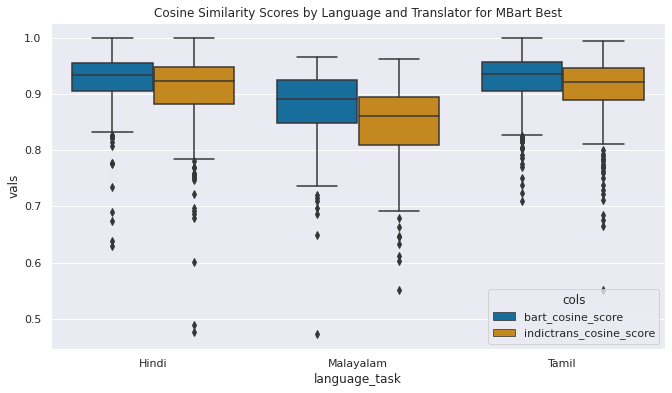

In [45]:
# Plot the reshaped values
sns.set(rc={'figure.figsize':(11,6)})
sns.boxplot(x = df['language_task'],
            y = df['vals'],
            hue = df['cols'], palette="colorblind").set_title('Cosine Similarity Scores by Language and Translator for MBart Best')

When IndicTrans' translations are chosen as being "better", they too are more semantically similar to the target text as measured by cosine similarity than the MBart translations that were not chosen.

Text(0.5, 1.0, 'Cosine Similarity Scores by Language and Translator for IndicTrans Best')

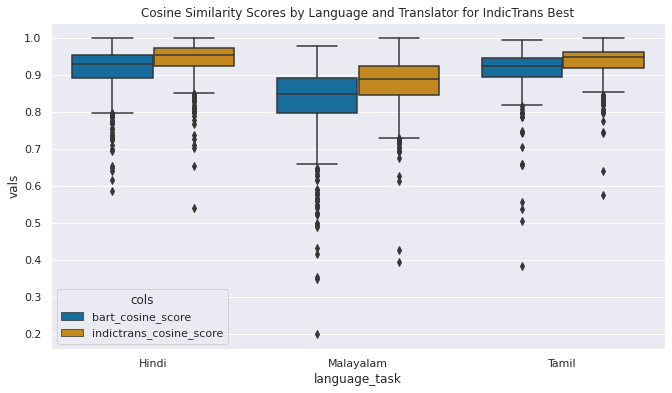

In [46]:
# Repeat for IndicTrans cosine scores when IndicTrans' translations are chosen as better
df2 = indic_chosen[["language_task", "bart_cosine_score", "indictrans_cosine_score"]]

# Use melt to reshape the values and allow for multiple column plotting
df2 = df2.melt('language_task', var_name='cols',  value_name='vals')

sns.boxplot(x = df2['language_task'],
            y = df2['vals'],
            hue = df2['cols'], palette="colorblind").set_title('Cosine Similarity Scores by Language and Translator for IndicTrans Best')

Text(0.5, 1.0, 'Cosine Similarity Scores by Language and Translator (Bart, IndicTrans, or Ensemble)')

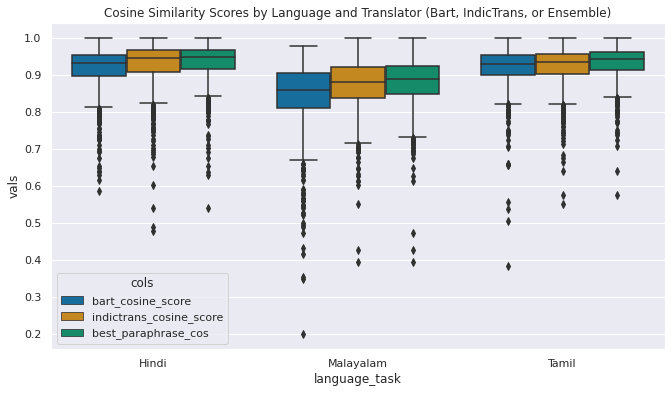

In [47]:
# Compare the MBart, IndicTrans, and Best Translation cosine similarity scores by language over the entire dataset
translator_cos_compare = final[["language_task", "bart_cosine_score", "indictrans_cosine_score", "best_paraphrase_cos"]]

# Use melt to reshape the values and allow for multiple column plotting
translator_cos_compare = translator_cos_compare.melt('language_task', var_name='cols',  value_name='vals')

# The median cosine similarity score is highest when the ensemble method is used
sns.boxplot(x = translator_cos_compare['language_task'],
            y = translator_cos_compare['vals'],
            hue = translator_cos_compare['cols'], palette="colorblind").set_title('Cosine Similarity Scores by Language and Translator (Bart, IndicTrans, or Ensemble)')

In [55]:
# Get the median cosine scores overall
# The ensemble method results in a higher median cosine similarity score
print(translator_cos_compare.groupby('cols', as_index=False)['vals'].median(), "\n")

#  Get the median cosine scores by language and translator
# The ensemble method results in a higher median cosine similarity score for Hindi, Malayalam, and Tamil
print(translator_cos_compare.groupby(['language_task', 'cols'], as_index=False)['vals'].median())


                      cols      vals
0        bart_cosine_score  0.913600
1      best_paraphrase_cos  0.929733
2  indictrans_cosine_score  0.923634 

  language_task                     cols      vals
0         Hindi        bart_cosine_score  0.931233
1         Hindi      best_paraphrase_cos  0.948123
2         Hindi  indictrans_cosine_score  0.946205
3     Malayalam        bart_cosine_score  0.859585
4     Malayalam      best_paraphrase_cos  0.889961
5     Malayalam  indictrans_cosine_score  0.881433
6         Tamil        bart_cosine_score  0.930840
7         Tamil      best_paraphrase_cos  0.942361
8         Tamil  indictrans_cosine_score  0.935245


Text(0.5, 1.0, 'Edit Distances by Language and Translator (Bart, IndicTrans, or Ensemble)')

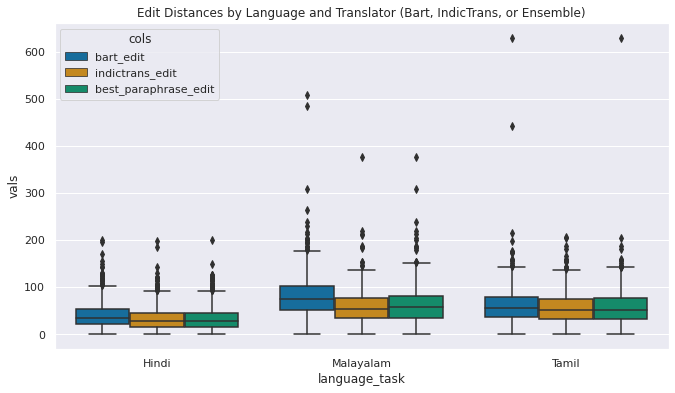

In [51]:
# Compare the MBart, IndicTrans, and Best Translation cosine similarity scores by language over the entire dataset
translator_edit_compare = final[["language_task", "bart_edit", "indictrans_edit", "best_paraphrase_edit"]]

# Use melt to reshape the values and allow for multiple column plotting
translator_edit_compare = translator_edit_compare.melt('language_task', var_name='cols',  value_name='vals')

# The median cosine similarity score is highest when the ensemble method is used
sns.boxplot(x = translator_edit_compare['language_task'],
            y = translator_edit_compare['vals'],
            hue = translator_edit_compare['cols'], palette="colorblind").set_title('Edit Distances by Language and Translator (Bart, IndicTrans, or Ensemble)')

In [56]:
# Get the median edit distances overall
# The ensemble method results in a higher median edit distance than IndicTrans, but less than MBart
print(translator_edit_compare.groupby('cols', as_index=False)['vals'].median(), "\n")

#  Get the median edit distances by language and translator
# The ensemble method results in a higher median cosine similarity score for Hindi and Malayalam, but has the same median edit distance as IndicTrans for Tamil (both are better than MBart)
print(translator_edit_compare.groupby(['language_task', 'cols'], as_index=False)['vals'].median())

                   cols  vals
0             bart_edit    54
1  best_paraphrase_edit    46
2       indictrans_edit    44 

  language_task                  cols  vals
0         Hindi             bart_edit  36.0
1         Hindi  best_paraphrase_edit  29.0
2         Hindi       indictrans_edit  28.5
3     Malayalam             bart_edit  75.0
4     Malayalam  best_paraphrase_edit  58.0
5     Malayalam       indictrans_edit  55.0
6         Tamil             bart_edit  55.5
7         Tamil  best_paraphrase_edit  53.0
8         Tamil       indictrans_edit  53.0
